מתחיל עיבוד של הקובץ: yolo_dataset.csv
נטענו 55117 שורות נתונים
קובץ test_yolo_dataset.csv נשמר בהצלחה.
מספר דוגמאות: 28174
מספר מאפיינים: 24
מספר קלאסים לברך דומיננטית: 2
מספר קלאסים למרפק דומיננטי: 2
Epoch 1/100
563/564 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - dominant_elbow_accuracy: 0.5585 - dominant_elbow_loss: 0.7549 - dominant_knee_accuracy: 0.5042 - dominant_knee_loss: 0.7779 - loss: 7.6908 - movement_score_loss: 6.1579 - movement_score_mae: 1.7516
Epoch 1: val_loss improved from inf to 2.92440, saving model to best_yolo_infant_movement_model.keras
564/564 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - dominant_elbow_accuracy: 0.5586 - dominant_elbow_loss: 0.7547 - dominant_knee_accuracy: 0.5042 - dominant_knee_loss: 0.7778 - loss: 7.6794 - movement_score_loss: 6.1469 - movement_score_mae: 1.7498 - val_dominant_elbow_accuracy: 0.5468 - val_dominant_elbow_loss: 0.6628 - val_dominant_knee_accuracy: 0.4953 - val_dominant_knee_loss: 0.6999 - val_loss: 2.9244 - val_movement_score_loss: 1.5617 - va

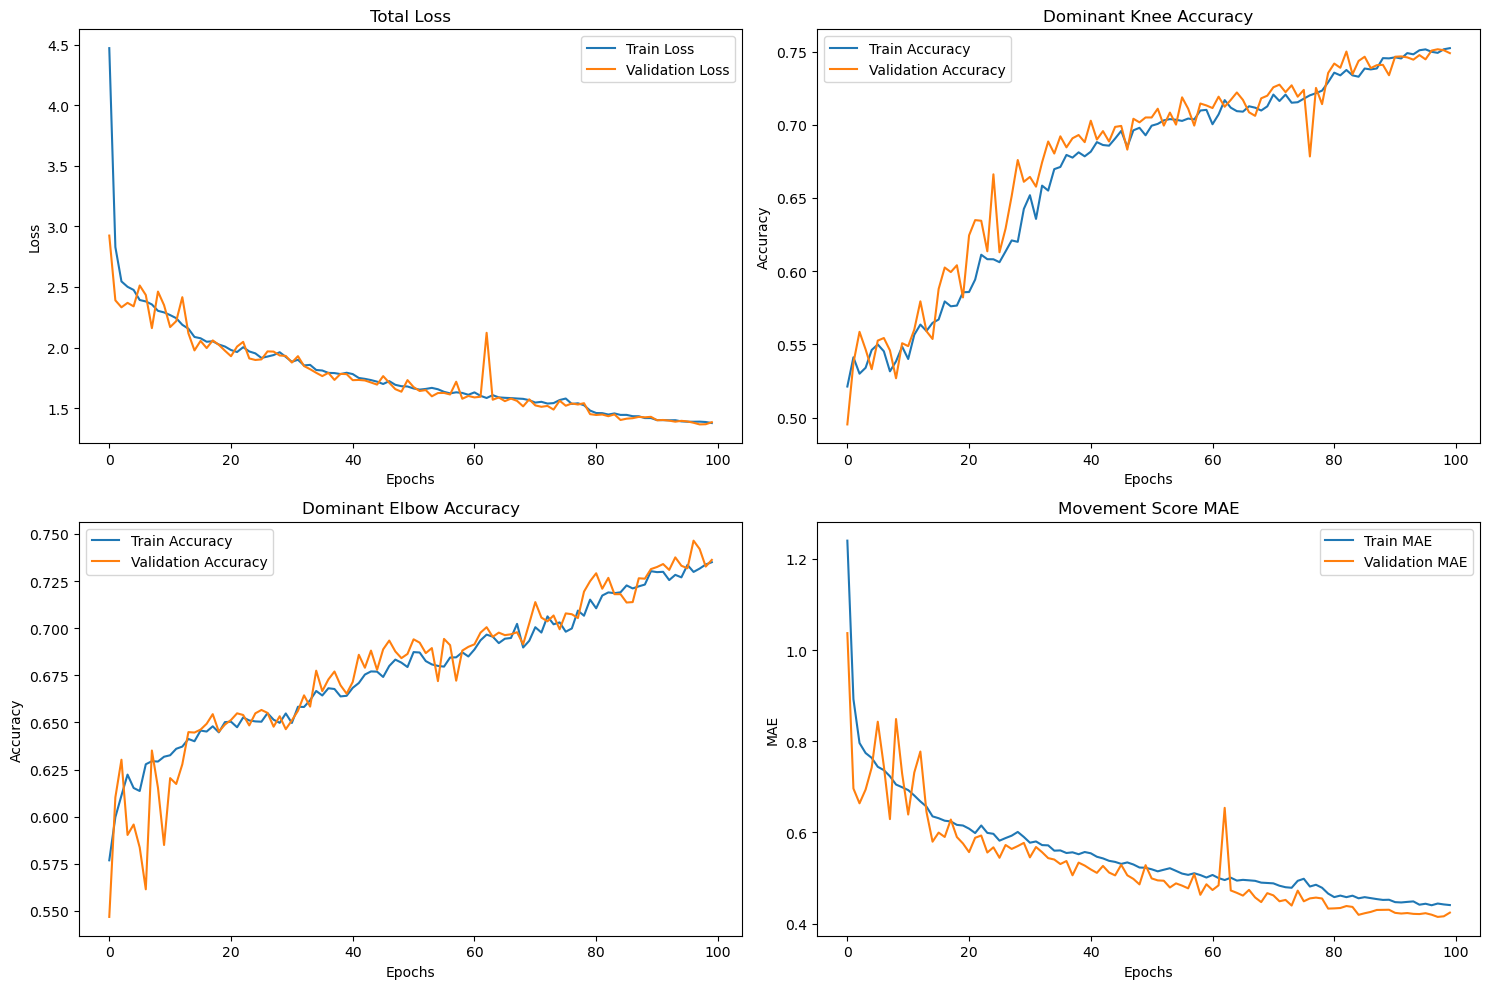

המודל נשמר בהצלחה כקובץ 'infant_yolo_movement_gru_model.keras'

האימון הסתיים בהצלחה!


In [3]:
'''
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import GRU, Dense, Input, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report
import os
import glob

# הגדרת פרמטרים
WINDOW_SIZE = 30  # מספר הפריימים ברצף (ניתן לשינוי בהתאם לצרכים)
RANDOM_STATE = 42
BATCH_SIZE = 32
EPOCHS = 100
LEARNING_RATE = 0.001

def load_and_preprocess_data(file_paths, window_size=WINDOW_SIZE):
    """
    טעינה ועיבוד מקדים של הנתונים מקבצי האקסל
    """
    all_data = []
    test_data = []

    for file_path in file_paths:
        df = pd.read_csv(file_path) if file_path.endswith('.csv') else pd.read_excel(file_path)
        
        # בדיקה שקיימים העמודות הנדרשות
        required_columns = ['video_id', 'frame', 'window_id', 
                           'overall_movement_score', 'dominant_knee', 'dominant_elbow']
        
        if not all(col in df.columns for col in required_columns):
            print(f"The file {file_path} is missing required columns. Skipping...")
            continue
        test_subset = df[df['video_id'].isin([43, 44])]
        if not test_subset.empty:
            test_data.append(test_subset)
        df = df[~df['video_id'].isin([43, 44])]
        all_data.append(df)
    
    if not all_data:
        raise ValueError("No valid files found for processing")
        
    # איחוד כל הנתונים
    data = pd.concat(all_data, ignore_index=True)
    
    # המרת ערכים קטגוריאליים למספרים
    label_encoders = {}
    for col in ['dominant_knee', 'dominant_elbow']:
        if data[col].dtype == 'object':
            le = LabelEncoder()
            data[col] = le.fit_transform(data[col])
            label_encoders[col] = le
    
    return data, label_encoders, test_data


def prepare_sequences(data, window_size=WINDOW_SIZE):
    """
    הכנת רצפי נתונים עבור GRU לפי חלונות
    """
    feature_columns = [col for col in data.columns if any(x in col for x in ['_x', '_y', '_confidence'])
                        and not any(skip in col.lower() for skip in ['velocity', 'angle'])]
    
    X = []
    y_movement = []
    y_knee = []
    y_elbow = []
    
    # קיבוץ לפי וידאו וחלון
    groups = data.groupby(['video_id', 'window_id'])
    
    for (vid_id, win_id), group in groups:
        if len(group) < window_size:
            # דילוג על חלונות קטנים מדי
            continue
        
        # לכל חלון, ניקח רצפים באורך window_size
        for i in range(0, len(group) - window_size + 1):
            sequence = group.iloc[i:i+window_size][feature_columns].values
            
            # המטרות הן הערכים בפריים האחרון ברצף
            target_frame = group.iloc[i+window_size-1]
            
            X.append(sequence)
            y_movement.append(target_frame['overall_movement_score'])
            y_knee.append(target_frame['dominant_knee'])
            y_elbow.append(target_frame['dominant_elbow'])
    
    X = np.array(X)
    y_movement = np.array(y_movement)
    y_knee = np.array(y_knee)
    y_elbow = np.array(y_elbow)
    
    return X, y_movement, y_knee, y_elbow, feature_columns

def build_gru_model(input_shape, num_knee_classes, num_elbow_classes):
    """
    בניית מודל GRU עם מספר שכבות והתאמה למשימות מרובות
    """
    # שכבת הקלט המשותפת
    inputs = Input(shape=input_shape)
    
    # שכבות GRU משותפות
    x = GRU(128, return_sequences=True)(inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    
    x = GRU(64)(x)
    x = BatchNormalization()(x)
    shared_features = Dropout(0.3)(x)
    
    # ענף לציון תנועה כללי (רגרסיה)
    movement_output = Dense(32, activation='relu')(shared_features)
    movement_output = Dense(1, name='movement_score')(movement_output)
    
    # ענף לברך דומיננטית (סיווג)
    knee_output = Dense(32, activation='relu')(shared_features)
    knee_output = Dense(num_knee_classes, activation='softmax', name='dominant_knee')(knee_output)
    
    # ענף למרפק דומיננטי (סיווג)
    elbow_output = Dense(32, activation='relu')(shared_features)
    elbow_output = Dense(num_elbow_classes, activation='softmax', name='dominant_elbow')(elbow_output)
    
    # הגדרת המודל עם קלט ושלושה פלטים
    model = Model(inputs=inputs, outputs=[movement_output, knee_output, elbow_output])
    
    # הגדרת אופטימייזר ופונקציות שגיאה
    model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE),
        loss={
            'movement_score': 'mean_squared_error',
            'dominant_knee': 'sparse_categorical_crossentropy',
            'dominant_elbow': 'sparse_categorical_crossentropy'
        },
        metrics={
            'movement_score': ['mae'],
            'dominant_knee': ['accuracy'],
            'dominant_elbow': ['accuracy']
        }
    )
    
    return model

def train_model(X_train, y_train, X_val, y_val, input_shape, num_knee_classes, num_elbow_classes):
    """
    אימון המודל עם מנגנוני עצירה מוקדמת ושיפור ביצועים
    """
    model = build_gru_model(input_shape, num_knee_classes, num_elbow_classes)
    
    # הגדרת callbacks
    early_stopping = EarlyStopping(
        monitor='val_loss', 
        patience=15, 
        restore_best_weights=True
    )
    
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=0.00001
    )

    '''
        קובץ בו נשמר המודל שמתקבלת בו התוצאה הטובה ביותר על סט הוולידציה
    '''
    model_checkpoint = ModelCheckpoint(
        'best_yolo_infant_movement_model.keras', 
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
    
    # אימון המודל
    history = model.fit(
        X_train,
        y_train,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping, reduce_lr, model_checkpoint],
        verbose=1
    )
    
    return model, history

def evaluate_model(model, X_test, y_test_movement, y_test_knee, y_test_elbow, label_encoders):
    """
    הערכת המודל והצגת מדדי ביצוע
    """
    # ביצוע חיזוי
    y_pred_movement, y_pred_knee_prob, y_pred_elbow_prob = model.predict(X_test)
    
    # המרת הסתברויות לתוויות
    y_pred_knee = np.argmax(y_pred_knee_prob, axis=1)
    y_pred_elbow = np.argmax(y_pred_elbow_prob, axis=1)
    
    # מדדי ביצוע לציון תנועה כללי
    mse_movement = mean_squared_error(y_test_movement, y_pred_movement)
    '''
    ציון בין 0-10 שמודד עד כמה המודל שגה בחישוב ציון התנועה הכללי- כמה רחוק המודל היהי מהציון תנועה הכללי האמיתי שחושב
    '''
    rmse_movement = np.sqrt(mse_movement) 
    
    # מדדי ביצוע לסיווג ברך ומרפק דומיננטיים
    knee_accuracy = accuracy_score(y_test_knee, y_pred_knee)
    elbow_accuracy = accuracy_score(y_test_elbow, y_pred_elbow)
    
    print("\n===== תוצאות המודל =====")
    print(f"RMSE for motion score: {rmse_movement:.4f}")
    print(f"דיוק סיווג ברך דומיננטית: {knee_accuracy:.4f}")
    print(f"דיוק סיווג מרפק דומיננטי: {elbow_accuracy:.4f}")
    
    print("\nדוח סיווג - ברך דומיננטית:")
    print(classification_report(y_test_knee, y_pred_knee))
    
    print("\nדוח סיווג - מרפק דומיננטי:")
    print(classification_report(y_test_elbow, y_pred_elbow))
    
    # פענוח התוויות חזרה לערכים המקוריים (אם נדרש)
    if 'dominant_knee' in label_encoders:
        original_knee_labels = label_encoders['dominant_knee'].inverse_transform(range(len(label_encoders['dominant_knee'].classes_)))
        print("\nמיפוי תוויות ברך:")
        for i, label in enumerate(original_knee_labels):
            print(f"{i}: {label}")
    
    if 'dominant_elbow' in label_encoders:
        original_elbow_labels = label_encoders['dominant_elbow'].inverse_transform(range(len(label_encoders['dominant_elbow'].classes_)))
        print("\nמיפוי תוויות מרפק:")
        for i, label in enumerate(original_elbow_labels):
            print(f"{i}: {label}")
    
    return {
        'rmse_movement': rmse_movement,
        'knee_accuracy': knee_accuracy,
        'elbow_accuracy': elbow_accuracy
    }

def plot_training_history(history):
    """
    יצירת גרפים להצגת התקדמות האימון
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # עקומות שגיאה
    axes[0, 0].plot(history.history['loss'], label='Train Loss')
    axes[0, 0].plot(history.history['val_loss'], label='Validation Loss')
    axes[0, 0].set_title('Total Loss')
    axes[0, 0].set_xlabel('Epochs')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    
    # דיוק ברך דומיננטית
    axes[0, 1].plot(history.history['dominant_knee_accuracy'], label='Train Accuracy')
    axes[0, 1].plot(history.history['val_dominant_knee_accuracy'], label='Validation Accuracy')
    axes[0, 1].set_title('Dominant Knee Accuracy')
    axes[0, 1].set_xlabel('Epochs')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].legend()
    
    # דיוק מרפק דומיננטי
    axes[1, 0].plot(history.history['dominant_elbow_accuracy'], label='Train Accuracy')
    axes[1, 0].plot(history.history['val_dominant_elbow_accuracy'], label='Validation Accuracy')
    axes[1, 0].set_title('Dominant Elbow Accuracy')
    axes[1, 0].set_xlabel('Epochs')
    axes[1, 0].set_ylabel('Accuracy')
    axes[1, 0].legend()
    
    # שגיאה ממוצעת מוחלטת לציון תנועה
    axes[1, 1].plot(history.history['movement_score_mae'], label='Train MAE')
    axes[1, 1].plot(history.history['val_movement_score_mae'], label='Validation MAE')
    axes[1, 1].set_title('Movement Score MAE')
    axes[1, 1].set_xlabel('Epochs')
    axes[1, 1].set_ylabel('MAE')
    axes[1, 1].legend()
    
    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()

def main():
    # הגדרה ידנית של קובץ הנתונים
    file_paths = ['yolo_dataset.csv']
    
    if not os.path.exists('yolo_dataset.csv'):
        print("שגיאה: הקובץ 'yolo_dataset.csv' לא נמצא בתיקייה הנוכחית")
        return
    
    print(f"מתחיל עיבוד של הקובץ: {file_paths[0]}")
    
    # טעינת הנתונים
    try:
        data, label_encoders, test_data = load_and_preprocess_data(file_paths)
        print(f"נטענו {len(data)} שורות נתונים")
    except Exception as e:
        print(f"שגיאה בטעינת הנתונים: {e}")
        return

    if test_data:  # בדיקה שיש נתונים
        test_df = pd.concat(test_data, ignore_index=True)
        test_df.to_csv('test_yolo_dataset.csv', index=False)
        print("קובץ test_yolo_dataset.csv נשמר בהצלחה.")
    else:
        print("לא נמצאו נתוני test_data לשמירה.")
    
    # הכנת רצפי הנתונים
    X, y_movement, y_knee, y_elbow, feature_columns = prepare_sequences(data)
    
    print(f"מספר דוגמאות: {len(X)}")
    print(f"מספר מאפיינים: {X.shape[2]}")
    
    # ספירת מספר הקלאסים הייחודיים
    num_knee_classes = len(np.unique(y_knee))
    num_elbow_classes = len(np.unique(y_elbow))
    
    print(f"מספר קלאסים לברך דומיננטית: {num_knee_classes}")
    print(f"מספר קלאסים למרפק דומיננטי: {num_elbow_classes}")
    
    # חלוקת הנתונים לאימון ובדיקה
    X_train_val, X_test, y_movement_train_val, y_movement_test, \
    y_knee_train_val, y_knee_test, y_elbow_train_val, y_elbow_test = train_test_split(
        X, y_movement, y_knee, y_elbow, test_size=0.2, random_state=RANDOM_STATE
    )
    
    # חלוקה נוספת לאימון ותיקוף
    X_train, X_val, y_movement_train, y_movement_val, \
    y_knee_train, y_knee_val, y_elbow_train, y_elbow_val = train_test_split(
        X_train_val, y_movement_train_val, y_knee_train_val, y_elbow_train_val, 
        test_size=0.2, random_state=RANDOM_STATE
    )
    
    # נירמול הנתונים
    # אין צורך לנרמל את המאפיינים מאחר וכל דגימה היא רצף, 
    # ובמקום זאת נשתמש ב-BatchNormalization בתוך המודל
    
    # הגדרת צורת הקלט למודל
    input_shape = (X_train.shape[1], X_train.shape[2])
    
    # הגדרת הפלטים באופן מתאים לפורמט הנדרש עבור מודל עם פלט מרובה
    y_train = [y_movement_train, y_knee_train, y_elbow_train]
    y_val = [y_movement_val, y_knee_val, y_elbow_val]
    
    # אימון המודל
    model, history = train_model(
        X_train, y_train, X_val, y_val, 
        input_shape, num_knee_classes, num_elbow_classes
    )
    
    # הערכת המודל
    results = evaluate_model(
        model, X_test, y_movement_test, y_knee_test, y_elbow_test, label_encoders
    )
    
    # יצירת גרפים להצגת התקדמות האימון
    plot_training_history(history)
    
    # שמירת המודל
    '''
     הקובץ בו נשמר המודל האחרון לאחר סיום כל האפוקים (לא בהכרח הטוב ביותר
     '''
    model.save('infant_yolo_movement_gru_model.keras') 
    print("המודל נשמר בהצלחה כקובץ 'infant_yolo_movement_gru_model.keras'")
    
    # שמירת מידע על המאפיינים ששימשו לאימון (לשימוש עתידי)
    with open('model_features.txt', 'w') as f:
        f.write('\n'.join(feature_columns))
    
    print("\nהאימון הסתיים בהצלחה!")

if __name__ == "__main__":
    main()
    '''

מתחיל עיבוד של הקובץ: yolo_dataset.csv
נטענו 55117 שורות נתונים
קובץ test_yolo_dataset.csv נשמר בהצלחה.
מספר דוגמאות: 28174
מספר מאפיינים: 24
מספר קלאסים לברך דומיננטית: 2
מספר קלאסים למרפק דומיננטי: 2
Epoch 1/200


C:\Users\user\anaconda3\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


563/564 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - dominant_elbow_accuracy: 0.5706 - dominant_elbow_loss: 0.7129 - dominant_knee_accuracy: 0.5186 - dominant_knee_loss: 0.7685 - loss: 4.4776 - movement_score_loss: 2.9962 - movement_score_mae: 1.2503
Epoch 1: val_loss improved from inf to 4.52486, saving model to best_yolo_infant_movement_model.keras
564/564 ━━━━━━━━━━━━━━━━━━━━ 24s 33ms/step - dominant_elbow_accuracy: 0.5707 - dominant_elbow_loss: 0.7128 - dominant_knee_accuracy: 0.5187 - dominant_knee_loss: 0.7683 - loss: 4.4739 - movement_score_loss: 2.9929 - movement_score_mae: 1.2495 - val_dominant_elbow_accuracy: 0.5572 - val_dominant_elbow_loss: 0.7096 - val_dominant_knee_accuracy: 0.5244 - val_dominant_knee_loss: 0.6993 - val_loss: 4.5249 - val_movement_score_loss: 3.1158 - val_movement_score_mae: 1.5766 - learning_rate: 0.0010
Epoch 2/200
562/564 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - dominant_elbow_accuracy: 0.6008 - dominant_elbow_loss: 0.6452 - dominant_knee_accuracy: 0.5352 - dominant

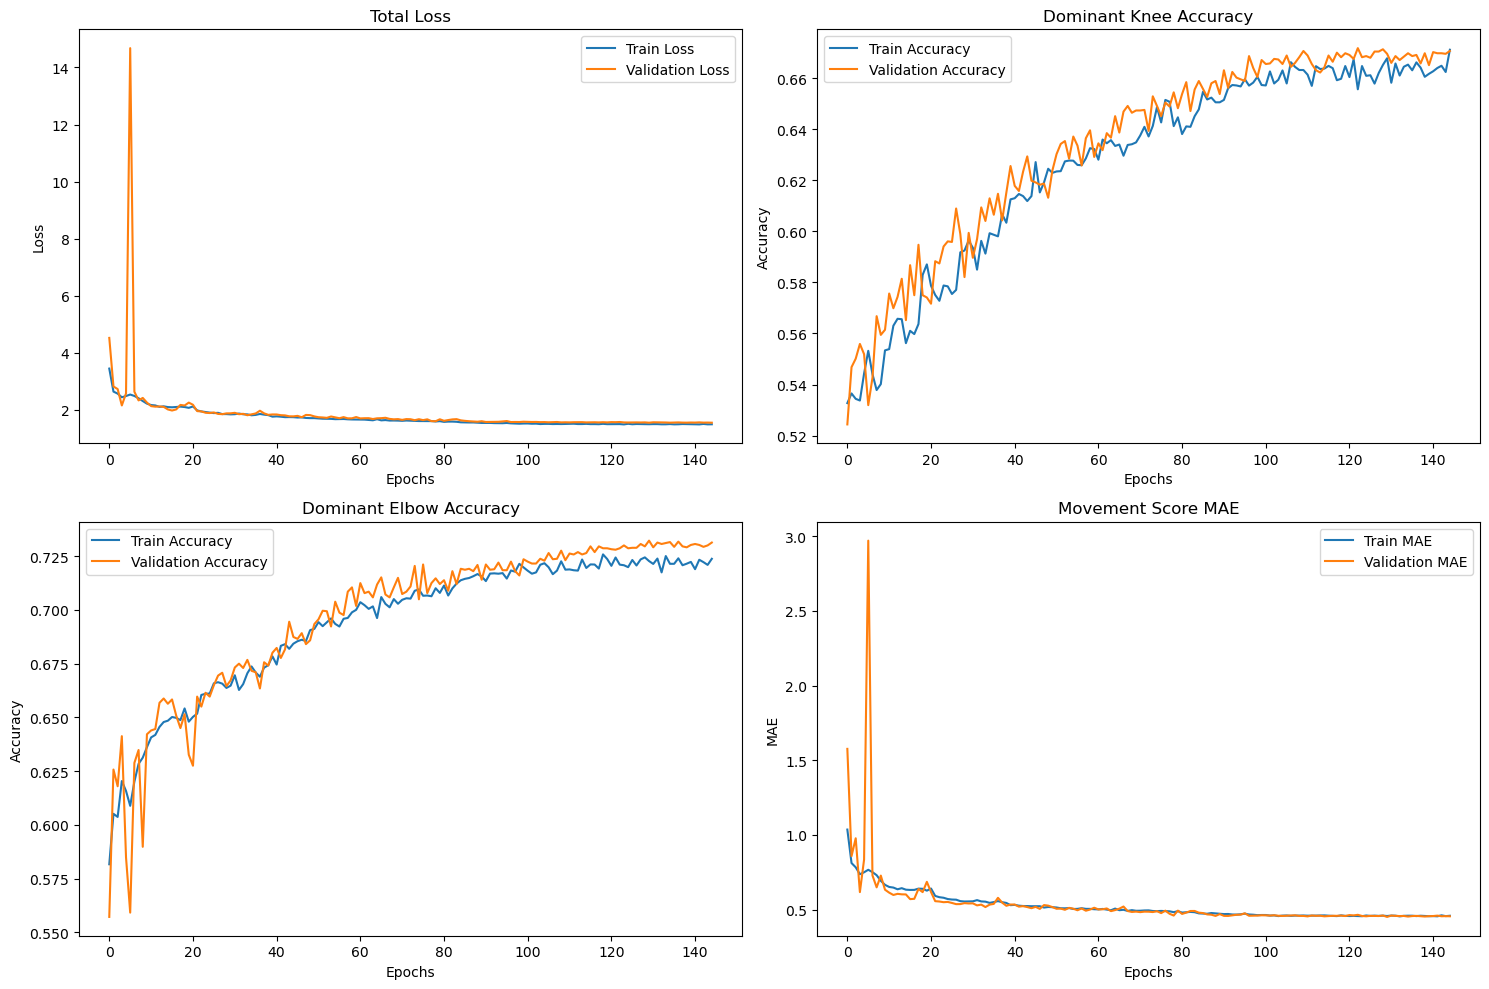

המודל נשמר בהצלחה כקובץ 'infant_yolo_movement_gru_model.keras'

האימון הסתיים בהצלחה!


In [5]:
'''
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import GRU, Dense, Input, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report
import os
import glob
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import ReLU
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Dense, Lambda

# הגדרת פרמטרים
WINDOW_SIZE = 30  # מספר הפריימים ברצף (ניתן לשינוי בהתאם לצרכים)
RANDOM_STATE = 42
BATCH_SIZE = 32
EPOCHS = 200
LEARNING_RATE = 0.001

def load_and_preprocess_data(file_paths, window_size=WINDOW_SIZE):
    """
    טעינה ועיבוד מקדים של הנתונים מקבצי האקסל
    """
    all_data = []
    test_data = []

    for file_path in file_paths:
        df = pd.read_csv(file_path) if file_path.endswith('.csv') else pd.read_excel(file_path)
        
        # בדיקה שקיימים העמודות הנדרשות
        required_columns = ['video_id', 'frame', 'window_id', 
                           'overall_movement_score', 'dominant_knee', 'dominant_elbow']
        
        if not all(col in df.columns for col in required_columns):
            print(f"The file {file_path} is missing required columns. Skipping...")
            continue
        test_subset = df[df['video_id'].isin([43, 44])]
        if not test_subset.empty:
            test_data.append(test_subset)
        df = df[~df['video_id'].isin([43, 44])]
        all_data.append(df)
    
    if not all_data:
        raise ValueError("No valid files found for processing")
        
    # איחוד כל הנתונים
    data = pd.concat(all_data, ignore_index=True)
    
    # המרת ערכים קטגוריאליים למספרים
    label_encoders = {}
    for col in ['dominant_knee', 'dominant_elbow']:
        if data[col].dtype == 'object':
            le = LabelEncoder()
            data[col] = le.fit_transform(data[col])
            label_encoders[col] = le
    
    return data, label_encoders, test_data


def prepare_sequences(data, window_size=WINDOW_SIZE):
    """
    הכנת רצפי נתונים עבור GRU לפי חלונות
    """
    feature_columns = [col for col in data.columns if any(x in col for x in ['_x', '_y', '_confidence'])
                        and not any(skip in col.lower() for skip in ['velocity', 'angle'])]
    
    X = []
    y_movement = []
    y_knee = []
    y_elbow = []
    
    # קיבוץ לפי וידאו וחלון
    groups = data.groupby(['video_id', 'window_id'])
    
    for (vid_id, win_id), group in groups:
        if len(group) < window_size:
            # דילוג על חלונות קטנים מדי
            continue
        
        # לכל חלון, ניקח רצפים באורך window_size
        for i in range(0, len(group) - window_size + 1):
            sequence = group.iloc[i:i+window_size][feature_columns].values
            
            # המטרות הן הערכים בפריים האחרון ברצף
            target_frame = group.iloc[i+window_size-1]
            
            X.append(sequence)
            y_movement.append(target_frame['overall_movement_score'])
            y_knee.append(target_frame['dominant_knee'])
            y_elbow.append(target_frame['dominant_elbow'])
    
    X = np.array(X)
    y_movement = np.array(y_movement)
    y_knee = np.array(y_knee)
    y_elbow = np.array(y_elbow)
    
    return X, y_movement, y_knee, y_elbow, feature_columns

def build_gru_model(input_shape, num_knee_classes, num_elbow_classes):
    """
    בניית מודל GRU עם מספר שכבות והתאמה למשימות מרובות
    """
    # שכבת הקלט המשותפת
    inputs = Input(shape=input_shape)
    
    # שכבות GRU משותפות
    x = GRU(128, return_sequences=True)(inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    
    x = GRU(64)(x)
    x = BatchNormalization()(x)
    shared_features = Dropout(0.3)(x)
    
    # ענף לציון תנועה כללי (רגרסיה)
    movement_output = Dense(32, activation='relu')(shared_features)
    movement_output = Dense(1)(movement_output)
    movement_output = ReLU(max_value=10, name='movement_score')(movement_output)
    
    # ענף לברך דומיננטית (סיווג)
    knee_output = Dense(32)(shared_features)
    knee_output = LeakyReLU(alpha=0.01)(knee_output)
    knee_output = Dense(num_knee_classes, activation='softmax', name='dominant_knee')(knee_output)
    
    # ענף למרפק דומיננטי (סיווג)
    elbow_output = Dense(32)(shared_features)
    elbow_output = LeakyReLU(alpha=0.01)(elbow_output)
    elbow_output = Dense(num_elbow_classes, activation='softmax', name='dominant_elbow')(elbow_output)
    
    # הגדרת המודל עם קלט ושלושה פלטים
    model = Model(inputs=inputs, outputs=[movement_output, knee_output, elbow_output])
    
    # הגדרת אופטימייזר ופונקציות שגיאה
    model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE),
        loss={
            'movement_score': 'mean_squared_error',
            'dominant_knee': 'sparse_categorical_crossentropy',
            'dominant_elbow': 'sparse_categorical_crossentropy'
        },
        metrics={
            'movement_score': ['mae'],
            'dominant_knee': ['accuracy'],
            'dominant_elbow': ['accuracy']
        }
    )
    
    return model

def train_model(X_train, y_train, X_val, y_val, input_shape, num_knee_classes, num_elbow_classes):
    """
    אימון המודל עם מנגנוני עצירה מוקדמת ושיפור ביצועים
    """
    model = build_gru_model(input_shape, num_knee_classes, num_elbow_classes)
    
    # הגדרת callbacks
    early_stopping = EarlyStopping(
        monitor='val_loss', 
        patience=15, 
        restore_best_weights=True
    )
    
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=0.00001
    )

    '''
        קובץ בו נשמר המודל שמתקבלת בו התוצאה הטובה ביותר על סט הוולידציה
    '''
    model_checkpoint = ModelCheckpoint(
        'best_yolo_infant_movement_model.keras', 
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
    
    # אימון המודל
    history = model.fit(
        X_train,
        y_train,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping, reduce_lr, model_checkpoint],
        verbose=1
    )
    
    return model, history

def evaluate_model(model, X_test, y_test_movement, y_test_knee, y_test_elbow, label_encoders):
    """
    הערכת המודל והצגת מדדי ביצוע
    """
    # ביצוע חיזוי
    y_pred_movement, y_pred_knee_prob, y_pred_elbow_prob = model.predict(X_test)
    
    # המרת הסתברויות לתוויות
    y_pred_knee = np.argmax(y_pred_knee_prob, axis=1)
    y_pred_elbow = np.argmax(y_pred_elbow_prob, axis=1)
    
    # מדדי ביצוע לציון תנועה כללי
    mse_movement = mean_squared_error(y_test_movement, y_pred_movement)
    '''
    ציון בין 0-10 שמודד עד כמה המודל שגה בחישוב ציון התנועה הכללי- כמה רחוק המודל היהי מהציון תנועה הכללי האמיתי שחושב
    '''
    rmse_movement = np.sqrt(mse_movement) 
    
    # מדדי ביצוע לסיווג ברך ומרפק דומיננטיים
    knee_accuracy = accuracy_score(y_test_knee, y_pred_knee)
    elbow_accuracy = accuracy_score(y_test_elbow, y_pred_elbow)
    
    print("\n===== תוצאות המודל =====")
    print(f"RMSE for motion score: {rmse_movement:.4f}")
    print(f"דיוק סיווג ברך דומיננטית: {knee_accuracy:.4f}")
    print(f"דיוק סיווג מרפק דומיננטי: {elbow_accuracy:.4f}")
    
    print("\nדוח סיווג - ברך דומיננטית:")
    print(classification_report(y_test_knee, y_pred_knee))
    
    print("\nדוח סיווג - מרפק דומיננטי:")
    print(classification_report(y_test_elbow, y_pred_elbow))
    
    # פענוח התוויות חזרה לערכים המקוריים (אם נדרש)
    if 'dominant_knee' in label_encoders:
        original_knee_labels = label_encoders['dominant_knee'].inverse_transform(range(len(label_encoders['dominant_knee'].classes_)))
        print("\nמיפוי תוויות ברך:")
        for i, label in enumerate(original_knee_labels):
            print(f"{i}: {label}")
    
    if 'dominant_elbow' in label_encoders:
        original_elbow_labels = label_encoders['dominant_elbow'].inverse_transform(range(len(label_encoders['dominant_elbow'].classes_)))
        print("\nמיפוי תוויות מרפק:")
        for i, label in enumerate(original_elbow_labels):
            print(f"{i}: {label}")
    
    return {
        'rmse_movement': rmse_movement,
        'knee_accuracy': knee_accuracy,
        'elbow_accuracy': elbow_accuracy
    }

def plot_training_history(history):
    """
    יצירת גרפים להצגת התקדמות האימון
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # עקומות שגיאה
    axes[0, 0].plot(history.history['loss'], label='Train Loss')
    axes[0, 0].plot(history.history['val_loss'], label='Validation Loss')
    axes[0, 0].set_title('Total Loss')
    axes[0, 0].set_xlabel('Epochs')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    
    # דיוק ברך דומיננטית
    axes[0, 1].plot(history.history['dominant_knee_accuracy'], label='Train Accuracy')
    axes[0, 1].plot(history.history['val_dominant_knee_accuracy'], label='Validation Accuracy')
    axes[0, 1].set_title('Dominant Knee Accuracy')
    axes[0, 1].set_xlabel('Epochs')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].legend()
    
    # דיוק מרפק דומיננטי
    axes[1, 0].plot(history.history['dominant_elbow_accuracy'], label='Train Accuracy')
    axes[1, 0].plot(history.history['val_dominant_elbow_accuracy'], label='Validation Accuracy')
    axes[1, 0].set_title('Dominant Elbow Accuracy')
    axes[1, 0].set_xlabel('Epochs')
    axes[1, 0].set_ylabel('Accuracy')
    axes[1, 0].legend()
    
    # שגיאה ממוצעת מוחלטת לציון תנועה
    axes[1, 1].plot(history.history['movement_score_mae'], label='Train MAE')
    axes[1, 1].plot(history.history['val_movement_score_mae'], label='Validation MAE')
    axes[1, 1].set_title('Movement Score MAE')
    axes[1, 1].set_xlabel('Epochs')
    axes[1, 1].set_ylabel('MAE')
    axes[1, 1].legend()
    
    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()

def main():
    # הגדרה ידנית של קובץ הנתונים
    file_paths = ['yolo_dataset.csv']
    
    if not os.path.exists('yolo_dataset.csv'):
        print("שגיאה: הקובץ 'yolo_dataset.csv' לא נמצא בתיקייה הנוכחית")
        return
    
    print(f"מתחיל עיבוד של הקובץ: {file_paths[0]}")
    
    # טעינת הנתונים
    try:
        data, label_encoders, test_data = load_and_preprocess_data(file_paths)
        print(f"נטענו {len(data)} שורות נתונים")
    except Exception as e:
        print(f"שגיאה בטעינת הנתונים: {e}")
        return

    if test_data:  # בדיקה שיש נתונים
        test_df = pd.concat(test_data, ignore_index=True)
        test_df.to_csv('test_yolo_dataset.csv', index=False)
        print("קובץ test_yolo_dataset.csv נשמר בהצלחה.")
    else:
        print("לא נמצאו נתוני test_data לשמירה.")
    
    # הכנת רצפי הנתונים
    X, y_movement, y_knee, y_elbow, feature_columns = prepare_sequences(data)
    
    print(f"מספר דוגמאות: {len(X)}")
    print(f"מספר מאפיינים: {X.shape[2]}")
    
    # ספירת מספר הקלאסים הייחודיים
    num_knee_classes = len(np.unique(y_knee))
    num_elbow_classes = len(np.unique(y_elbow))
    
    print(f"מספר קלאסים לברך דומיננטית: {num_knee_classes}")
    print(f"מספר קלאסים למרפק דומיננטי: {num_elbow_classes}")
    
    # חלוקת הנתונים לאימון ובדיקה
    X_train_val, X_test, y_movement_train_val, y_movement_test, \
    y_knee_train_val, y_knee_test, y_elbow_train_val, y_elbow_test = train_test_split(
        X, y_movement, y_knee, y_elbow, test_size=0.2, random_state=RANDOM_STATE
    )
    
    # חלוקה נוספת לאימון ותיקוף
    X_train, X_val, y_movement_train, y_movement_val, \
    y_knee_train, y_knee_val, y_elbow_train, y_elbow_val = train_test_split(
        X_train_val, y_movement_train_val, y_knee_train_val, y_elbow_train_val, 
        test_size=0.2, random_state=RANDOM_STATE
    )
    
    # נירמול הנתונים
    # אין צורך לנרמל את המאפיינים מאחר וכל דגימה היא רצף, 
    # ובמקום זאת נשתמש ב-BatchNormalization בתוך המודל
    
    # הגדרת צורת הקלט למודל
    input_shape = (X_train.shape[1], X_train.shape[2])
    
    # הגדרת הפלטים באופן מתאים לפורמט הנדרש עבור מודל עם פלט מרובה
    y_train = [y_movement_train, y_knee_train, y_elbow_train]
    y_val = [y_movement_val, y_knee_val, y_elbow_val]
    
    # אימון המודל
    model, history = train_model(
        X_train, y_train, X_val, y_val, 
        input_shape, num_knee_classes, num_elbow_classes
    )
    
    # הערכת המודל
    results = evaluate_model(
        model, X_test, y_movement_test, y_knee_test, y_elbow_test, label_encoders
    )
    
    # יצירת גרפים להצגת התקדמות האימון
    plot_training_history(history)
    
    # שמירת המודל
    '''
     הקובץ בו נשמר המודל האחרון לאחר סיום כל האפוקים (לא בהכרח הטוב ביותר
     '''
    model.save('infant_yolo_movement_gru_model.keras') 
    print("המודל נשמר בהצלחה כקובץ 'infant_yolo_movement_gru_model.keras'")
    
    # שמירת מידע על המאפיינים ששימשו לאימון (לשימוש עתידי)
    with open('model_features.txt', 'w') as f:
        f.write('\n'.join(feature_columns))
    
    print("\nהאימון הסתיים בהצלחה!")

if __name__ == "__main__":
    main()
    '''

מתחיל עיבוד של הקובץ: yolo_dataset.csv
נטענו 55117 שורות נתונים
קובץ test_yolo_dataset.csv נשמר בהצלחה.
מספר דוגמאות: 28174
מספר מאפיינים: 24
מספר קלאסים לברך דומיננטית: 2
מספר קלאסים למרפק דומיננטי: 2
Epoch 1/300
563/564 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - dominant_elbow_accuracy: 0.5572 - dominant_elbow_loss: 0.7343 - dominant_knee_accuracy: 0.5130 - dominant_knee_loss: 0.7834 - loss: 5.6121 - movement_score_loss: 4.0944 - movement_score_mae: 1.4471
Epoch 1: val_loss improved from inf to 2.72529, saving model to best_yolo_infant_movement_model.keras
564/564 ━━━━━━━━━━━━━━━━━━━━ 42s 58ms/step - dominant_elbow_accuracy: 0.5573 - dominant_elbow_loss: 0.7341 - dominant_knee_accuracy: 0.5130 - dominant_knee_loss: 0.7833 - loss: 5.6057 - movement_score_loss: 4.0884 - movement_score_mae: 1.4458 - val_dominant_elbow_accuracy: 0.5723 - val_dominant_elbow_loss: 0.6501 - val_dominant_knee_accuracy: 0.5373 - val_dominant_knee_loss: 0.7043 - val_loss: 2.7253 - val_movement_score_loss: 1.3709 - va

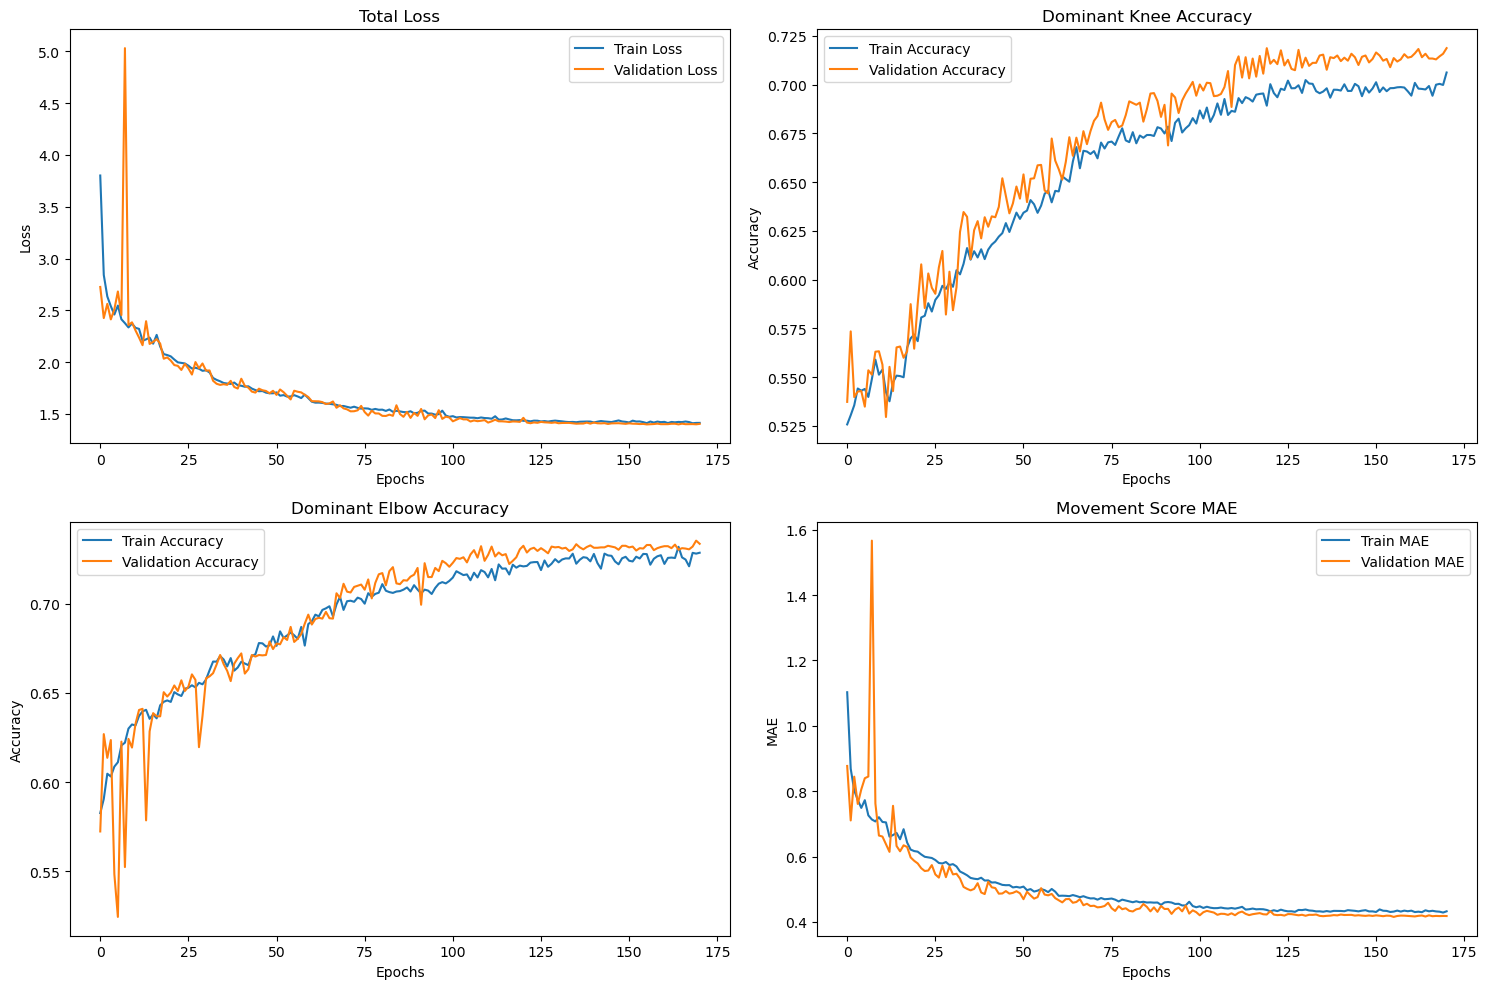

המודל נשמר בהצלחה כקובץ 'infant_yolo_movement_gru_model.keras'

האימון הסתיים בהצלחה!


In [9]:
'''
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import GRU, Dense, Input, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report
import os
import glob
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import ReLU
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Dense, Lambda

# הגדרת פרמטרים
WINDOW_SIZE = 30  # מספר הפריימים ברצף (ניתן לשינוי בהתאם לצרכים)
RANDOM_STATE = 42
BATCH_SIZE = 32
EPOCHS = 300
LEARNING_RATE = 0.001

def load_and_preprocess_data(file_paths, window_size=WINDOW_SIZE):
    """
    טעינה ועיבוד מקדים של הנתונים מקבצי האקסל
    """
    all_data = []
    test_data = []

    for file_path in file_paths:
        df = pd.read_csv(file_path) if file_path.endswith('.csv') else pd.read_excel(file_path)
        
        # בדיקה שקיימים העמודות הנדרשות
        required_columns = ['video_id', 'frame', 'window_id', 
                           'overall_movement_score', 'dominant_knee', 'dominant_elbow']
        
        if not all(col in df.columns for col in required_columns):
            print(f"The file {file_path} is missing required columns. Skipping...")
            continue
        test_subset = df[df['video_id'].isin([43, 44])]
        if not test_subset.empty:
            test_data.append(test_subset)
        df = df[~df['video_id'].isin([43, 44])]
        all_data.append(df)
    
    if not all_data:
        raise ValueError("No valid files found for processing")
        
    # איחוד כל הנתונים
    data = pd.concat(all_data, ignore_index=True)
    
    # המרת ערכים קטגוריאליים למספרים
    label_encoders = {}
    for col in ['dominant_knee', 'dominant_elbow']:
        if data[col].dtype == 'object':
            le = LabelEncoder()
            data[col] = le.fit_transform(data[col])
            label_encoders[col] = le
    
    return data, label_encoders, test_data


def prepare_sequences(data, window_size=WINDOW_SIZE):
    """
    הכנת רצפי נתונים עבור GRU לפי חלונות
    """
    feature_columns = [col for col in data.columns if any(x in col for x in ['_x', '_y', '_confidence'])
                        and not any(skip in col.lower() for skip in ['velocity', 'angle'])]
    
    X = []
    y_movement = []
    y_knee = []
    y_elbow = []
    
    # קיבוץ לפי וידאו וחלון
    groups = data.groupby(['video_id', 'window_id'])
    
    for (vid_id, win_id), group in groups:
        if len(group) < window_size:
            # דילוג על חלונות קטנים מדי
            continue
        
        # לכל חלון, ניקח רצפים באורך window_size
        for i in range(0, len(group) - window_size + 1):
            sequence = group.iloc[i:i+window_size][feature_columns].values
            
            # המטרות הן הערכים בפריים האחרון ברצף
            target_frame = group.iloc[i+window_size-1]
            
            X.append(sequence)
            y_movement.append(target_frame['overall_movement_score'])
            y_knee.append(target_frame['dominant_knee'])
            y_elbow.append(target_frame['dominant_elbow'])
    
    X = np.array(X)
    y_movement = np.array(y_movement)
    y_knee = np.array(y_knee)
    y_elbow = np.array(y_elbow)
    
    return X, y_movement, y_knee, y_elbow, feature_columns

def build_gru_model(input_shape, num_knee_classes, num_elbow_classes):
    """
    בניית מודל GRU עם מספר שכבות והתאמה למשימות מרובות
    """
    # שכבת הקלט המשותפת
    inputs = Input(shape=input_shape)
    
    # שכבות GRU משותפות
    x = GRU(128, return_sequences=True)(inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    
    x = GRU(64)(x)
    x = BatchNormalization()(x)
    shared_features = Dropout(0.3)(x)
    
    # ענף לציון תנועה כללי (רגרסיה)
    movement_output = Dense(32, activation='relu')(shared_features)
    movement_output = Dense(1)(movement_output)
    movement_output = ReLU(max_value=10, name='movement_score')(movement_output)
    
    # ענף לברך דומיננטית (סיווג)
    knee_output = Dense(32, activation='relu')(shared_features)
    knee_output = Dense(num_knee_classes, activation='softmax', name='dominant_knee')(knee_output)
    
    # ענף למרפק דומיננטי (סיווג)
    elbow_output = Dense(32, activation='relu')(shared_features)
    elbow_output = Dense(num_elbow_classes, activation='softmax', name='dominant_elbow')(elbow_output)
    
    # הגדרת המודל עם קלט ושלושה פלטים
    model = Model(inputs=inputs, outputs=[movement_output, knee_output, elbow_output])
    
    # הגדרת אופטימייזר ופונקציות שגיאה
    model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE),
        loss={
            'movement_score': 'mean_squared_error',
            'dominant_knee': 'sparse_categorical_crossentropy',
            'dominant_elbow': 'sparse_categorical_crossentropy'
        },
        metrics={
            'movement_score': ['mae'],
            'dominant_knee': ['accuracy'],
            'dominant_elbow': ['accuracy']
        }
    )
    
    return model

def train_model(X_train, y_train, X_val, y_val, input_shape, num_knee_classes, num_elbow_classes):
    """
    אימון המודל עם מנגנוני עצירה מוקדמת ושיפור ביצועים
    """
    model = build_gru_model(input_shape, num_knee_classes, num_elbow_classes)
    
    # הגדרת callbacks
    early_stopping = EarlyStopping(
        monitor='val_loss', 
        patience=15, 
        restore_best_weights=True
    )
    
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=0.00001
    )

    '''
        קובץ בו נשמר המודל שמתקבלת בו התוצאה הטובה ביותר על סט הוולידציה
    '''
    model_checkpoint = ModelCheckpoint(
        'best_yolo_infant_movement_model.keras', 
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
    
    # אימון המודל
    history = model.fit(
        X_train,
        y_train,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping, reduce_lr, model_checkpoint],
        verbose=1
    )
    
    return model, history

def evaluate_model(model, X_test, y_test_movement, y_test_knee, y_test_elbow, label_encoders):
    """
    הערכת המודל והצגת מדדי ביצוע
    """
    # ביצוע חיזוי
    y_pred_movement, y_pred_knee_prob, y_pred_elbow_prob = model.predict(X_test)
    
    # המרת הסתברויות לתוויות
    y_pred_knee = np.argmax(y_pred_knee_prob, axis=1)
    y_pred_elbow = np.argmax(y_pred_elbow_prob, axis=1)
    
    # מדדי ביצוע לציון תנועה כללי
    mse_movement = mean_squared_error(y_test_movement, y_pred_movement)
    '''
    ציון בין 0-10 שמודד עד כמה המודל שגה בחישוב ציון התנועה הכללי- כמה רחוק המודל היהי מהציון תנועה הכללי האמיתי שחושב
    '''
    rmse_movement = np.sqrt(mse_movement) 
    
    # מדדי ביצוע לסיווג ברך ומרפק דומיננטיים
    knee_accuracy = accuracy_score(y_test_knee, y_pred_knee)
    elbow_accuracy = accuracy_score(y_test_elbow, y_pred_elbow)
    
    print("\n===== תוצאות המודל =====")
    print(f"RMSE for motion score: {rmse_movement:.4f}")
    print(f"דיוק סיווג ברך דומיננטית: {knee_accuracy:.4f}")
    print(f"דיוק סיווג מרפק דומיננטי: {elbow_accuracy:.4f}")
    
    print("\nדוח סיווג - ברך דומיננטית:")
    print(classification_report(y_test_knee, y_pred_knee))
    
    print("\nדוח סיווג - מרפק דומיננטי:")
    print(classification_report(y_test_elbow, y_pred_elbow))
    
    # פענוח התוויות חזרה לערכים המקוריים (אם נדרש)
    if 'dominant_knee' in label_encoders:
        original_knee_labels = label_encoders['dominant_knee'].inverse_transform(range(len(label_encoders['dominant_knee'].classes_)))
        print("\nמיפוי תוויות ברך:")
        for i, label in enumerate(original_knee_labels):
            print(f"{i}: {label}")
    
    if 'dominant_elbow' in label_encoders:
        original_elbow_labels = label_encoders['dominant_elbow'].inverse_transform(range(len(label_encoders['dominant_elbow'].classes_)))
        print("\nמיפוי תוויות מרפק:")
        for i, label in enumerate(original_elbow_labels):
            print(f"{i}: {label}")
    
    return {
        'rmse_movement': rmse_movement,
        'knee_accuracy': knee_accuracy,
        'elbow_accuracy': elbow_accuracy
    }

def plot_training_history(history):
    """
    יצירת גרפים להצגת התקדמות האימון
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # עקומות שגיאה
    axes[0, 0].plot(history.history['loss'], label='Train Loss')
    axes[0, 0].plot(history.history['val_loss'], label='Validation Loss')
    axes[0, 0].set_title('Total Loss')
    axes[0, 0].set_xlabel('Epochs')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    
    # דיוק ברך דומיננטית
    axes[0, 1].plot(history.history['dominant_knee_accuracy'], label='Train Accuracy')
    axes[0, 1].plot(history.history['val_dominant_knee_accuracy'], label='Validation Accuracy')
    axes[0, 1].set_title('Dominant Knee Accuracy')
    axes[0, 1].set_xlabel('Epochs')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].legend()
    
    # דיוק מרפק דומיננטי
    axes[1, 0].plot(history.history['dominant_elbow_accuracy'], label='Train Accuracy')
    axes[1, 0].plot(history.history['val_dominant_elbow_accuracy'], label='Validation Accuracy')
    axes[1, 0].set_title('Dominant Elbow Accuracy')
    axes[1, 0].set_xlabel('Epochs')
    axes[1, 0].set_ylabel('Accuracy')
    axes[1, 0].legend()
    
    # שגיאה ממוצעת מוחלטת לציון תנועה
    axes[1, 1].plot(history.history['movement_score_mae'], label='Train MAE')
    axes[1, 1].plot(history.history['val_movement_score_mae'], label='Validation MAE')
    axes[1, 1].set_title('Movement Score MAE')
    axes[1, 1].set_xlabel('Epochs')
    axes[1, 1].set_ylabel('MAE')
    axes[1, 1].legend()
    
    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()

def main():
    # הגדרה ידנית של קובץ הנתונים
    file_paths = ['yolo_dataset.csv']
    
    if not os.path.exists('yolo_dataset.csv'):
        print("שגיאה: הקובץ 'yolo_dataset.csv' לא נמצא בתיקייה הנוכחית")
        return
    
    print(f"מתחיל עיבוד של הקובץ: {file_paths[0]}")
    
    # טעינת הנתונים
    try:
        data, label_encoders, test_data = load_and_preprocess_data(file_paths)
        print(f"נטענו {len(data)} שורות נתונים")
    except Exception as e:
        print(f"שגיאה בטעינת הנתונים: {e}")
        return

    if test_data:  # בדיקה שיש נתונים
        test_df = pd.concat(test_data, ignore_index=True)
        test_df.to_csv('test_yolo_dataset.csv', index=False)
        print("קובץ test_yolo_dataset.csv נשמר בהצלחה.")
    else:
        print("לא נמצאו נתוני test_data לשמירה.")
    
    # הכנת רצפי הנתונים
    X, y_movement, y_knee, y_elbow, feature_columns = prepare_sequences(data)
    
    print(f"מספר דוגמאות: {len(X)}")
    print(f"מספר מאפיינים: {X.shape[2]}")
    
    # ספירת מספר הקלאסים הייחודיים
    num_knee_classes = len(np.unique(y_knee))
    num_elbow_classes = len(np.unique(y_elbow))
    
    print(f"מספר קלאסים לברך דומיננטית: {num_knee_classes}")
    print(f"מספר קלאסים למרפק דומיננטי: {num_elbow_classes}")
    
    # חלוקת הנתונים לאימון ובדיקה
    X_train_val, X_test, y_movement_train_val, y_movement_test, \
    y_knee_train_val, y_knee_test, y_elbow_train_val, y_elbow_test = train_test_split(
        X, y_movement, y_knee, y_elbow, test_size=0.2, random_state=RANDOM_STATE
    )
    
    # חלוקה נוספת לאימון ותיקוף
    X_train, X_val, y_movement_train, y_movement_val, \
    y_knee_train, y_knee_val, y_elbow_train, y_elbow_val = train_test_split(
        X_train_val, y_movement_train_val, y_knee_train_val, y_elbow_train_val, 
        test_size=0.2, random_state=RANDOM_STATE
    )
    
    # נירמול הנתונים
    # אין צורך לנרמל את המאפיינים מאחר וכל דגימה היא רצף, 
    # ובמקום זאת נשתמש ב-BatchNormalization בתוך המודל
    
    # הגדרת צורת הקלט למודל
    input_shape = (X_train.shape[1], X_train.shape[2])
    
    # הגדרת הפלטים באופן מתאים לפורמט הנדרש עבור מודל עם פלט מרובה
    y_train = [y_movement_train, y_knee_train, y_elbow_train]
    y_val = [y_movement_val, y_knee_val, y_elbow_val]
    
    # אימון המודל
    model, history = train_model(
        X_train, y_train, X_val, y_val, 
        input_shape, num_knee_classes, num_elbow_classes
    )
    
    # הערכת המודל
    results = evaluate_model(
        model, X_test, y_movement_test, y_knee_test, y_elbow_test, label_encoders
    )
    
    # יצירת גרפים להצגת התקדמות האימון
    plot_training_history(history)
    
    # שמירת המודל
    '''
     הקובץ בו נשמר המודל האחרון לאחר סיום כל האפוקים (לא בהכרח הטוב ביותר
     '''
    model.save('infant_yolo_movement_gru_model.keras') 
    print("המודל נשמר בהצלחה כקובץ 'infant_yolo_movement_gru_model.keras'")
    
    # שמירת מידע על המאפיינים ששימשו לאימון (לשימוש עתידי)
    with open('model_features.txt', 'w') as f:
        f.write('\n'.join(feature_columns))
    
    print("\nהאימון הסתיים בהצלחה!")

if __name__ == "__main__":
    main()
    '''

מתחיל עיבוד של הקובץ: yolo_dataset.csv
נטענו 55117 שורות נתונים
קובץ test_yolo_dataset.csv נשמר בהצלחה.
מספר דוגמאות: 28174
מספר מאפיינים: 24
מספר קלאסים לברך דומיננטית: 2
מספר קלאסים למרפק דומיננטי: 2
Epoch 1/300


C:\Users\user\anaconda3\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


563/564 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - dominant_elbow_accuracy: 0.5538 - dominant_elbow_loss: 0.7496 - dominant_knee_accuracy: 0.5162 - dominant_knee_loss: 0.7658 - loss: 6.2793 - movement_score_loss: 4.7639 - movement_score_mae: 1.5698
Epoch 1: val_loss improved from inf to 2.32777, saving model to best_yolo_infant_movement_model.keras
564/564 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - dominant_elbow_accuracy: 0.5539 - dominant_elbow_loss: 0.7494 - dominant_knee_accuracy: 0.5162 - dominant_knee_loss: 0.7656 - loss: 6.2712 - movement_score_loss: 4.7561 - movement_score_mae: 1.5683 - val_dominant_elbow_accuracy: 0.6074 - val_dominant_elbow_loss: 0.6360 - val_dominant_knee_accuracy: 0.5368 - val_dominant_knee_loss: 0.6854 - val_loss: 2.3278 - val_movement_score_loss: 1.0060 - val_movement_score_mae: 0.6910 - learning_rate: 0.0010
Epoch 2/300
563/564 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - dominant_elbow_accuracy: 0.5954 - dominant_elbow_loss: 0.6638 - dominant_knee_accuracy: 0.5216 - dominant

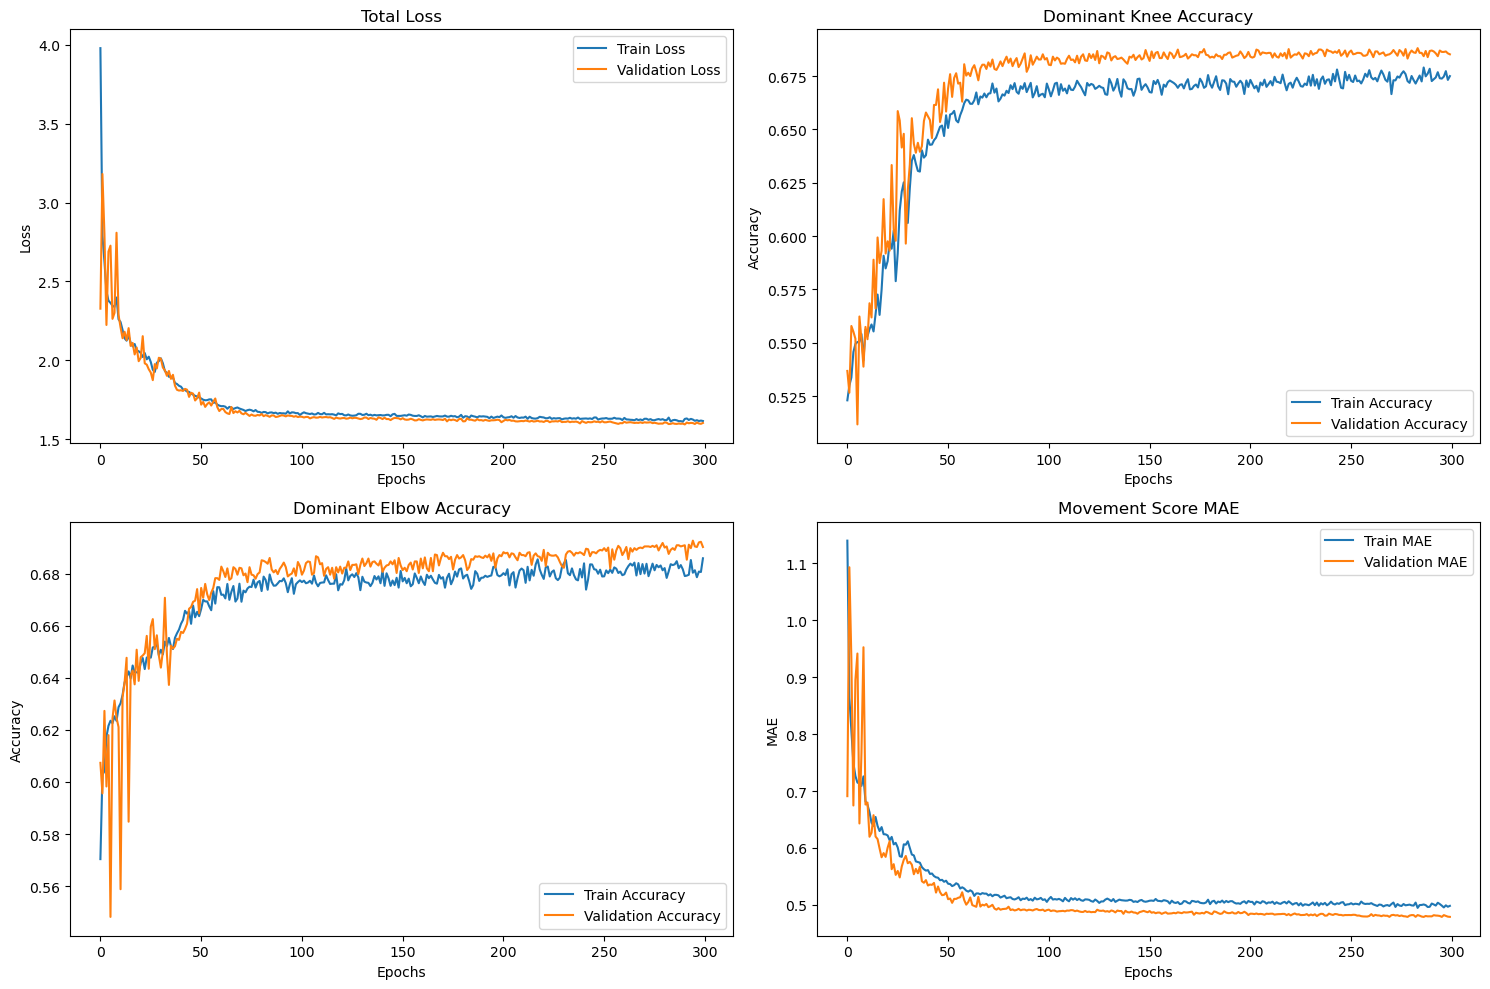

המודל נשמר בהצלחה כקובץ 'infant_yolo_movement_gru_model.keras'

האימון הסתיים בהצלחה!


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import GRU, Dense, Input, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report
import os
import glob
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import ReLU
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Dense, Lambda

# הגדרת פרמטרים
WINDOW_SIZE = 30  # מספר הפריימים ברצף (ניתן לשינוי בהתאם לצרכים)
RANDOM_STATE = 42
BATCH_SIZE = 32
EPOCHS = 300
LEARNING_RATE = 0.001

def load_and_preprocess_data(file_paths, window_size=WINDOW_SIZE):
    """
    טעינה ועיבוד מקדים של הנתונים מקבצי האקסל
    """
    all_data = []
    test_data = []

    for file_path in file_paths:
        df = pd.read_csv(file_path) if file_path.endswith('.csv') else pd.read_excel(file_path)
        
        # בדיקה שקיימים העמודות הנדרשות
        required_columns = ['video_id', 'frame', 'window_id', 
                           'overall_movement_score', 'dominant_knee', 'dominant_elbow']
        
        if not all(col in df.columns for col in required_columns):
            print(f"The file {file_path} is missing required columns. Skipping...")
            continue
        test_subset = df[df['video_id'].isin([43, 44])]
        if not test_subset.empty:
            test_data.append(test_subset)
        df = df[~df['video_id'].isin([43, 44])]
        all_data.append(df)
    
    if not all_data:
        raise ValueError("No valid files found for processing")
        
    # איחוד כל הנתונים
    data = pd.concat(all_data, ignore_index=True)
    
    # המרת ערכים קטגוריאליים למספרים
    label_encoders = {}
    for col in ['dominant_knee', 'dominant_elbow']:
        if data[col].dtype == 'object':
            le = LabelEncoder()
            data[col] = le.fit_transform(data[col])
            label_encoders[col] = le
    
    return data, label_encoders, test_data


def prepare_sequences(data, window_size=WINDOW_SIZE):
    """
    הכנת רצפי נתונים עבור GRU לפי חלונות
    """
    feature_columns = [col for col in data.columns if any(x in col for x in ['_x', '_y', '_confidence'])
                        and not any(skip in col.lower() for skip in ['velocity', 'angle'])]
    
    X = []
    y_movement = []
    y_knee = []
    y_elbow = []
    
    # קיבוץ לפי וידאו וחלון
    groups = data.groupby(['video_id', 'window_id'])
    
    for (vid_id, win_id), group in groups:
        if len(group) < window_size:
            # דילוג על חלונות קטנים מדי
            continue
        
        # לכל חלון, ניקח רצפים באורך window_size
        for i in range(0, len(group) - window_size + 1):
            sequence = group.iloc[i:i+window_size][feature_columns].values
            
            # המטרות הן הערכים בפריים האחרון ברצף
            target_frame = group.iloc[i+window_size-1]
            
            X.append(sequence)
            y_movement.append(target_frame['overall_movement_score'])
            y_knee.append(target_frame['dominant_knee'])
            y_elbow.append(target_frame['dominant_elbow'])
    
    X = np.array(X)
    y_movement = np.array(y_movement)
    y_knee = np.array(y_knee)
    y_elbow = np.array(y_elbow)
    
    return X, y_movement, y_knee, y_elbow, feature_columns

def build_gru_model(input_shape, num_knee_classes, num_elbow_classes):
    """
    בניית מודל GRU עם מספר שכבות והתאמה למשימות מרובות
    """
    # שכבת הקלט המשותפת
    inputs = Input(shape=input_shape)
    
    # שכבות GRU משותפות
    x = GRU(128, return_sequences=True)(inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    
    x = GRU(64)(x)
    x = BatchNormalization()(x)
    shared_features = Dropout(0.3)(x)
    
    # ענף לציון תנועה כללי (רגרסיה)
    movement_output = Dense(32, activation='relu')(shared_features)
    movement_output = Dense(1)(movement_output)
    movement_output = ReLU(max_value=10, name='movement_score')(movement_output)
    
    # ענף לברך דומיננטית (סיווג)
    knee_output = Dense(32)(shared_features)
    knee_output = LeakyReLU(alpha=0.01)(knee_output)
    knee_output = Dense(num_knee_classes, activation='softmax', name='dominant_knee')(knee_output)
    
    # ענף למרפק דומיננטי (סיווג)
    elbow_output = Dense(32)(shared_features)
    elbow_output = LeakyReLU(alpha=0.01)(elbow_output)
    elbow_output = Dense(num_elbow_classes, activation='softmax', name='dominant_elbow')(elbow_output)
    
    # הגדרת המודל עם קלט ושלושה פלטים
    model = Model(inputs=inputs, outputs=[movement_output, knee_output, elbow_output])
    
    # הגדרת אופטימייזר ופונקציות שגיאה
    model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE),
        loss={
            'movement_score': 'mean_squared_error',
            'dominant_knee': 'sparse_categorical_crossentropy',
            'dominant_elbow': 'sparse_categorical_crossentropy'
        },
        metrics={
            'movement_score': ['mae'],
            'dominant_knee': ['accuracy'],
            'dominant_elbow': ['accuracy']
        }
    )
    
    return model

def train_model(X_train, y_train, X_val, y_val, input_shape, num_knee_classes, num_elbow_classes):
    """
    אימון המודל עם מנגנוני עצירה מוקדמת ושיפור ביצועים
    """
    model = build_gru_model(input_shape, num_knee_classes, num_elbow_classes)
    
    # הגדרת callbacks
    early_stopping = EarlyStopping(
        monitor='val_loss', 
        patience=50, 
        restore_best_weights=True
    )
    
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=0.00001
    )

    '''
        קובץ בו נשמר המודל שמתקבלת בו התוצאה הטובה ביותר על סט הוולידציה
    '''
    model_checkpoint = ModelCheckpoint(
        'best_yolo_infant_movement_model.keras', 
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
    
    # אימון המודל
    history = model.fit(
        X_train,
        y_train,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping, reduce_lr, model_checkpoint],
        verbose=1
    )
    
    return model, history

def evaluate_model(model, X_test, y_test_movement, y_test_knee, y_test_elbow, label_encoders):
    """
    הערכת המודל והצגת מדדי ביצוע
    """
    # ביצוע חיזוי
    y_pred_movement, y_pred_knee_prob, y_pred_elbow_prob = model.predict(X_test)
    
    # המרת הסתברויות לתוויות
    y_pred_knee = np.argmax(y_pred_knee_prob, axis=1)
    y_pred_elbow = np.argmax(y_pred_elbow_prob, axis=1)
    
    # מדדי ביצוע לציון תנועה כללי
    mse_movement = mean_squared_error(y_test_movement, y_pred_movement)
    '''
    ציון בין 0-10 שמודד עד כמה המודל שגה בחישוב ציון התנועה הכללי- כמה רחוק המודל היהי מהציון תנועה הכללי האמיתי שחושב
    '''
    rmse_movement = np.sqrt(mse_movement) 
    
    # מדדי ביצוע לסיווג ברך ומרפק דומיננטיים
    knee_accuracy = accuracy_score(y_test_knee, y_pred_knee)
    elbow_accuracy = accuracy_score(y_test_elbow, y_pred_elbow)
    
    print("\n===== תוצאות המודל =====")
    print(f"RMSE for motion score: {rmse_movement:.4f}")
    print(f"דיוק סיווג ברך דומיננטית: {knee_accuracy:.4f}")
    print(f"דיוק סיווג מרפק דומיננטי: {elbow_accuracy:.4f}")
    
    print("\nדוח סיווג - ברך דומיננטית:")
    print(classification_report(y_test_knee, y_pred_knee))
    
    print("\nדוח סיווג - מרפק דומיננטי:")
    print(classification_report(y_test_elbow, y_pred_elbow))
    
    # פענוח התוויות חזרה לערכים המקוריים (אם נדרש)
    if 'dominant_knee' in label_encoders:
        original_knee_labels = label_encoders['dominant_knee'].inverse_transform(range(len(label_encoders['dominant_knee'].classes_)))
        print("\nמיפוי תוויות ברך:")
        for i, label in enumerate(original_knee_labels):
            print(f"{i}: {label}")
    
    if 'dominant_elbow' in label_encoders:
        original_elbow_labels = label_encoders['dominant_elbow'].inverse_transform(range(len(label_encoders['dominant_elbow'].classes_)))
        print("\nמיפוי תוויות מרפק:")
        for i, label in enumerate(original_elbow_labels):
            print(f"{i}: {label}")
    
    return {
        'rmse_movement': rmse_movement,
        'knee_accuracy': knee_accuracy,
        'elbow_accuracy': elbow_accuracy
    }

def plot_training_history(history):
    """
    יצירת גרפים להצגת התקדמות האימון
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # עקומות שגיאה
    axes[0, 0].plot(history.history['loss'], label='Train Loss')
    axes[0, 0].plot(history.history['val_loss'], label='Validation Loss')
    axes[0, 0].set_title('Total Loss')
    axes[0, 0].set_xlabel('Epochs')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    
    # דיוק ברך דומיננטית
    axes[0, 1].plot(history.history['dominant_knee_accuracy'], label='Train Accuracy')
    axes[0, 1].plot(history.history['val_dominant_knee_accuracy'], label='Validation Accuracy')
    axes[0, 1].set_title('Dominant Knee Accuracy')
    axes[0, 1].set_xlabel('Epochs')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].legend()
    
    # דיוק מרפק דומיננטי
    axes[1, 0].plot(history.history['dominant_elbow_accuracy'], label='Train Accuracy')
    axes[1, 0].plot(history.history['val_dominant_elbow_accuracy'], label='Validation Accuracy')
    axes[1, 0].set_title('Dominant Elbow Accuracy')
    axes[1, 0].set_xlabel('Epochs')
    axes[1, 0].set_ylabel('Accuracy')
    axes[1, 0].legend()
    
    # שגיאה ממוצעת מוחלטת לציון תנועה
    axes[1, 1].plot(history.history['movement_score_mae'], label='Train MAE')
    axes[1, 1].plot(history.history['val_movement_score_mae'], label='Validation MAE')
    axes[1, 1].set_title('Movement Score MAE')
    axes[1, 1].set_xlabel('Epochs')
    axes[1, 1].set_ylabel('MAE')
    axes[1, 1].legend()
    
    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()

def main():
    # הגדרה ידנית של קובץ הנתונים
    file_paths = ['yolo_dataset.csv']
    
    if not os.path.exists('yolo_dataset.csv'):
        print("שגיאה: הקובץ 'yolo_dataset.csv' לא נמצא בתיקייה הנוכחית")
        return
    
    print(f"מתחיל עיבוד של הקובץ: {file_paths[0]}")
    
    # טעינת הנתונים
    try:
        data, label_encoders, test_data = load_and_preprocess_data(file_paths)
        print(f"נטענו {len(data)} שורות נתונים")
    except Exception as e:
        print(f"שגיאה בטעינת הנתונים: {e}")
        return

    if test_data:  # בדיקה שיש נתונים
        test_df = pd.concat(test_data, ignore_index=True)
        test_df.to_csv('test_yolo_dataset.csv', index=False)
        print("קובץ test_yolo_dataset.csv נשמר בהצלחה.")
    else:
        print("לא נמצאו נתוני test_data לשמירה.")
    
    # הכנת רצפי הנתונים
    X, y_movement, y_knee, y_elbow, feature_columns = prepare_sequences(data)
    
    print(f"מספר דוגמאות: {len(X)}")
    print(f"מספר מאפיינים: {X.shape[2]}")
    
    # ספירת מספר הקלאסים הייחודיים
    num_knee_classes = len(np.unique(y_knee))
    num_elbow_classes = len(np.unique(y_elbow))
    
    print(f"מספר קלאסים לברך דומיננטית: {num_knee_classes}")
    print(f"מספר קלאסים למרפק דומיננטי: {num_elbow_classes}")
    
    # חלוקת הנתונים לאימון ובדיקה
    X_train_val, X_test, y_movement_train_val, y_movement_test, \
    y_knee_train_val, y_knee_test, y_elbow_train_val, y_elbow_test = train_test_split(
        X, y_movement, y_knee, y_elbow, test_size=0.2, random_state=RANDOM_STATE
    )
    
    # חלוקה נוספת לאימון ותיקוף
    X_train, X_val, y_movement_train, y_movement_val, \
    y_knee_train, y_knee_val, y_elbow_train, y_elbow_val = train_test_split(
        X_train_val, y_movement_train_val, y_knee_train_val, y_elbow_train_val, 
        test_size=0.2, random_state=RANDOM_STATE
    )
    
    # נירמול הנתונים
    # אין צורך לנרמל את המאפיינים מאחר וכל דגימה היא רצף, 
    # ובמקום זאת נשתמש ב-BatchNormalization בתוך המודל
    
    # הגדרת צורת הקלט למודל
    input_shape = (X_train.shape[1], X_train.shape[2])
    
    # הגדרת הפלטים באופן מתאים לפורמט הנדרש עבור מודל עם פלט מרובה
    y_train = [y_movement_train, y_knee_train, y_elbow_train]
    y_val = [y_movement_val, y_knee_val, y_elbow_val]
    
    # אימון המודל
    model, history = train_model(
        X_train, y_train, X_val, y_val, 
        input_shape, num_knee_classes, num_elbow_classes
    )
    
    # הערכת המודל
    results = evaluate_model(
        model, X_test, y_movement_test, y_knee_test, y_elbow_test, label_encoders
    )
    
    # יצירת גרפים להצגת התקדמות האימון
    plot_training_history(history)
    
    # שמירת המודל
    '''
     הקובץ בו נשמר המודל האחרון לאחר סיום כל האפוקים (לא בהכרח הטוב ביותר
     '''
    model.save('infant_yolo_movement_gru_model.keras') 
    print("המודל נשמר בהצלחה כקובץ 'infant_yolo_movement_gru_model.keras'")
    
    # שמירת מידע על המאפיינים ששימשו לאימון (לשימוש עתידי)
    with open('model_features.txt', 'w') as f:
        f.write('\n'.join(feature_columns))
    
    print("\nהאימון הסתיים בהצלחה!")

if __name__ == "__main__":
    main()